# Exploratory Guide for Long-Short Term Memory Neural Networks (LSTM)

This guide recreates the LSTM for Time Series article written by Jason Brownlee for machinelearningmastery.com

In [1]:
%cd ..
%cd .. 
%cd data

/Users/azel/github/Data-Science/jupyter_notebooks
/Users/azel/github/Data-Science
/Users/azel/github/Data-Science/data


In [95]:
from fin_data import DailyTimeSeries
import numpy as np
import pandas as pd
import os, sys

from sklearn.preprocessing import MinMaxScaler

    
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [104]:
def split(cut, X, y):
    """
    Temporal Train Test Split. Holdout is most recent data.  
    """
    
    # Train Test Split: 70% Train, 30% Test
    X_train = X[:int(len(X)*cut)]
    X_test= X[int(len(X)*cut):len(X)]
    y_train=y[:int(len(y)*cut)]
    y_test=y[int(len(y)*cut):len(y)]
    
    return X_train, X_test, y_train, y_test
    

### Univariate LSTM Model

In [4]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    
    for i in range (len(sequence)):
        #find the end of this pattern
        end_ix = i + n_steps
        # check to see if we are at the end of the sequence
        if end_ix > len(sequence)-1:
                break
        #gather input and output parts of the pattern
        seq_X, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_X)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [5]:
raw_seq = np.arange(start=10, stop=200, step=10)
n_steps = 5

X, y = split_sequence(raw_seq, n_steps)

for i in range(len(X)):
    print(X[i], y[i])

[10 20 30 40 50] 60
[20 30 40 50 60] 70
[30 40 50 60 70] 80
[40 50 60 70 80] 90
[50 60 70 80 90] 100
[ 60  70  80  90 100] 110
[ 70  80  90 100 110] 120
[ 80  90 100 110 120] 130
[ 90 100 110 120 130] 140
[100 110 120 130 140] 150
[110 120 130 140 150] 160
[120 130 140 150 160] 170
[130 140 150 160 170] 180
[140 150 160 170 180] 190


In [6]:
#from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [7]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [8]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=200, verbose=0)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [9]:
#Creating next input
x_input = np.array([150, 160, 170,180,190])
#reshaping to the proper sequence
x_input = x_input.reshape((1, n_steps, n_features))

In [10]:
y_pred = model.predict(x_input, verbose=0)
print('The Prediction should be 200, is it?')
print('prediction: ', y_pred[0][0])

The Prediction should be 200, is it?
prediction:  198.98883


Now, let's apply this to the S&P500

In [11]:
#Get data for Apple
apple = DailyTimeSeries('AAPL')
adf = apple.initiate()
#Create Univariate Time Series 
data = adf[['AAPL close']]

################################################################### 
 Ticker:  AAPL 
 Last Refreshed:  2019-09-03 11:03:23 
 Data Retrieved:  Daily Prices (open, high, low, close) and Volumes 
 ###################################################################


In [12]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


values = [x for x in range(10)]
d = series_to_supervised(values)
d

,var1(t-1),var1(t)
1,0.0,1
2,1.0,2
3,2.0,3
4,3.0,4
5,4.0,5
6,5.0,6
7,6.0,7
8,7.0,8
9,8.0,9


In [13]:
data = series_to_supervised(data=data, n_in=3)

In [14]:
X = data.drop(columns='var1(t)')
y = data['var1(t)']

In [15]:
X_train, X_test, y_train, y_test = split(cut=0.8, X=X, y=y)

In [16]:
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [17]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, 
          epochs=200,
          validation_data=(X_test, y_test),
          verbose=0)

scores = model.evaluate(X_test, y_test)
print('Neural Network MSE: ', scores)

1007/1007 [==============================] - 0s 24us/step
Neural Network MSE:  8.19445793583708


### Stacked LSTM

Multiple hidden LSTM layers can be stacked one on top of another in what is referred to as a Stacked LSTM model.

An LSTM layer requires a three-dimensional input and LSTMs by default will produce a two-dimensional output as an interpretation from the end of the sequence.

We can address this by having the LSTM output a value for each time step in the input data by setting the return_sequences=True argument on the layer. This allows us to have 3D output from hidden LSTM layer as input to the next.

We can therefore define a Stacked LSTM as follows.

In [18]:
model= Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, 
          epochs=200,
          validation_data=(X_test, y_test),
          verbose=0)

scores = model.evaluate(X_test, y_test)
print('Neural Network MSE: ', scores)

1007/1007 [==============================] - 0s 29us/step
Neural Network MSE:  9.247217992803428


### Bidirectional LSTM

On some sequence prediction problems, it can be beneficial to allow the LSTM model to learn the input sequence both forward and backwards and concatenate both interpretations.

This is called a Bidirectional LSTM.

We can implement a Bidirectional LSTM for univariate time series forecasting by wrapping the first hidden layer in a wrapper layer called Bidirectional.

An example of defining a Bidirectional LSTM to read input both forward and backward is as follows.

In [19]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, 
          epochs=200,
          validation_data=(X_test, y_test),
          verbose=0)

scores = model.evaluate(X_test, y_test)
print('Neural Network MSE: ', scores)

1007/1007 [==============================] - 0s 23us/step
Neural Network MSE:  7.887479213403969


### Multivariate LSTM Model

In [20]:
#Create Input
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
#Create target
out_seq

array([ 25,  45,  65,  85, 105, 125, 145, 165, 185])

In [21]:
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
dataset

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

In [22]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [23]:
# define input sequence
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

n_features = X.shape[2]

print(X.shape, y.shape,'\n')
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

(7, 3, 2) (7,) 

[[10 15]
 [20 25]
 [30 35]] 65
[[20 25]
 [30 35]
 [40 45]] 85
[[30 35]
 [40 45]
 [50 55]] 105
[[40 45]
 [50 55]
 [60 65]] 125
[[50 55]
 [60 65]
 [70 75]] 145
[[60 65]
 [70 75]
 [80 85]] 165
[[70 75]
 [80 85]
 [90 95]] 185


We can see that the X component has a three-dimensional structure.

The first dimension is the number of samples, in this case 7. The second dimension is the number of time steps per sample, in this case 3, the value specified to the function. Finally, the last dimension specifies the number of parallel time series or the number of variables, in this case 2 for the two parallel series.

This is the exact three-dimensional structure expected by an LSTM as input. The data is ready to use without further reshaping.

We can then see that the input and output for each sample is printed, showing the three time steps for each of the two input series and the associated output for each sample.

In [24]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=200, verbose=0)

x_input = np.array([[80, 85], [90, 95], [100, 105]])
x_input = x_input.reshape((1, n_steps, n_features))
model.predict(x_input, verbose=0)

array([[209.71779]], dtype=float32)

Let's try this with Apple's data

In [25]:
adf.head()

,AAPL open,AAPL high,AAPL low,AAPL close,AAPL volume
date,,,,,
2019-09-03,206.43,206.98,204.22,205.20,6473443.0
2019-08-30,210.16,210.45,207.20,208.74,19540438.0
2019-08-29,208.50,209.32,206.66,209.01,20990500.0
2019-08-28,204.10,205.72,203.32,205.53,15938800.0
2019-08-27,207.86,208.55,203.53,204.16,25873300.0


In [26]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [27]:
#Get data for Apple
apple = DailyTimeSeries('AAPL')
adf = apple.initiate()
#Create Univariate Time Series 
data = adf[['AAPL close']]

adf['target'] = adf['AAPL close'].shift(-1)

adf = adf.dropna()

X = adf.drop(columns='target')
y = adf['target']

################################################################### 
 Ticker:  AAPL 
 Last Refreshed:  2019-09-03 11:07:38 
 Data Retrieved:  Daily Prices (open, high, low, close) and Volumes 
 ###################################################################


In [28]:
X_train, X_test, y_train, y_test = split(cut=0.7, X=X, y=y)

In [29]:
train = TimeseriesGenerator(data=X_train.values, 
                            targets=y_train.values, 
                            length=20, 
                            sampling_rate=1, 
                            stride=1, 
                            start_index=0, 
                            end_index=None, 
                            shuffle=False, 
                            reverse=False, 
                            batch_size=60)


In [30]:
test = TimeseriesGenerator(data=X_test.values, 
                          targets=y_test.values, 
                          length=20, 
                          sampling_rate=1, 
                          stride=1, 
                          start_index=0, 
                          end_index=None, 
                          shuffle=False, 
                          reverse=False, 
                          batch_size=60)


In [31]:
batch_0 = train[0]
X_train, y_train = batch_0

batch_1 = test[0]
X_test, y_test = batch_1

In [32]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(100, activation='relu'))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model_history = model.fit(X_train, y_train, 
                          epochs=400,
                          validation_data=(X_test, y_test),
                          verbose=0)

scores = model.evaluate(X_test, y_test)
print('Neural Network MSE: ', scores)

60/60 [==============================] - 0s 229us/step
Neural Network MSE:  212443896763.73334


In [33]:
y_pred = model.predict(X_test)

In [34]:
from sklearn.metrics import r2_score

In [35]:
r2_score(y_pred, y_test)

-0.007675433444229052

In [36]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


<Figure size 640x480 with 1 Axes>

Well something clearly is going wrong. 

(128, 5, 5)

In [127]:
??TimeseriesGenerator

Init signature:
TimeseriesGenerator(
    data,
    targets,
    length,
    sampling_rate=1,
    stride=1,
    start_index=0,
    end_index=None,
    shuffle=False,
    reverse=False,
    batch_size=128,
)
Source:        
class TimeseriesGenerator(sequence.TimeseriesGenerator, utils.Sequence):
    """Utility class for generating batches of temporal data.

    This class takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    stride, length of history, etc., to produce batches for
    training/validation.

    # Arguments
        data: Indexable generator (such as list or Numpy array)
            containing consecutive data points (timesteps).
            The data should be at 2D, and axis 0 is expected
            to be the time dimension.
        targets: Targets corresponding to timesteps in `data`.
            It should have same length as `data`.
        length: Length of the output sequences (in number of timesteps).
      

In [135]:
def get_spx_data():
    
    with HiddenPrints():
        spx = DailyTimeSeries('SPX')
        df = spx.initiate()
        df = spx.add_securities(['VIX'], df)

        macros =["confidence_index", "trade_index", "longterm_rates"]

        df = spx.add_macro(df, macros)

        techs = ['SMA','EMA', 'MACD','STOCH','RSI','ADX', 'CCI', 'BBANDS', 'AD', 'OBV']

        df = spx.add_technicals(techs, df)
    
    return df


df = get_spx_data()

In [164]:
#df['target'] = ((df['SPX volume'].shift(-1) - df['SPX volume'])/(df['SPX volume']))*100
df['target'] = df['SPX close'].shift(-1)

df = df.dropna()

df = df.sort_values(by='date', ascending=True)

In [165]:
sc= MinMaxScaler()

X = sc.fit_transform(df.drop(columns='target'))
y = df['target'].values
#y = sc.fit_transform(df[['target']])

X_train, X_test, y_train, y_test = split(cut=0.85, X=X, y=y)

In [166]:
X_train.shape

(4151, 30)

In [167]:
train = TimeseriesGenerator(data=X_train, 
                            targets=y_train, 
                            length=50, 
                            sampling_rate=1, 
                            stride=1, 
                            start_index=0, 
                            end_index=None, 
                            shuffle=False, 
                            reverse=False, 
                            batch_size=X_train.shape[0])


In [168]:
test = TimeseriesGenerator(data=X_test, 
                          targets=y_test, 
                          length=50, 
                          sampling_rate=1, 
                          stride=1, 
                          start_index=0, 
                          end_index=None, 
                          shuffle=False, 
                          reverse=False, 
                          batch_size=X_test.shape[0])


In [169]:
batch_0 = train[0]
X_train, y_train = batch_0

batch_1 = test[0]
X_test, y_test = batch_1

In [170]:
model = Sequential()
model.add(LSTM(30, activation='relu', 
               return_sequences=True, 
               input_shape=(X_train.shape[1], 
                            X_train.shape[2])))
model.add(LSTM(30, return_sequences=True,
               activation='relu'))
model.add(LSTM(30, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model_history = model.fit(X_train, y_train, 
                          epochs=25,
                          validation_data=(X_test, y_test),
                          verbose=1)

scores = model.evaluate(X_test, y_test)
print('Neural Network MSE: ', scores)

Train on 4101 samples, validate on 683 samples
Epoch 1/25
4101/4101 [==============================] - 22s 5ms/step - loss: 1488852.8788 - val_loss: 4186254.6969
Epoch 2/25
4101/4101 [==============================] - 11s 3ms/step - loss: 1873003.4917 - val_loss: 6429912.9619
Epoch 3/25
4101/4101 [==============================] - 11s 3ms/step - loss: 331000.7587 - val_loss: 9624756.9039
Epoch 4/25
4101/4101 [==============================] - 11s 3ms/step - loss: 12433.9562 - val_loss: 5848440.9810
Epoch 5/25
4101/4101 [==============================] - 11s 3ms/step - loss: 9329.5305 - val_loss: 5396648.3493
Epoch 6/25
4101/4101 [==============================] - 11s 3ms/step - loss: 6833.0335 - val_loss: 4781935.8734
Epoch 7/25
4101/4101 [==============================] - 11s 3ms/step - loss: 7802.4479 - val_loss: 4655677.2659
Epoch 8/25
4101/4101 [==============================] - 11s 3ms/step - loss: 5929.2116 - val_loss: 5207689.2441
Epoch 9/25
4101/4101 [==========================

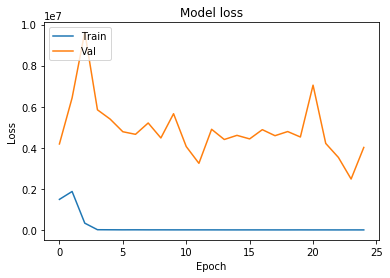

In [171]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [172]:
y_pred = model.predict(X_test)
r2_score(y_pred, y_test)

-0.318981789264956

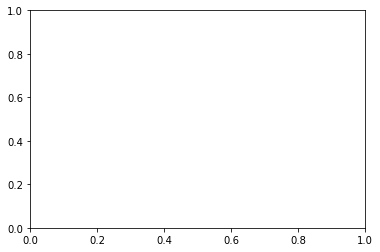

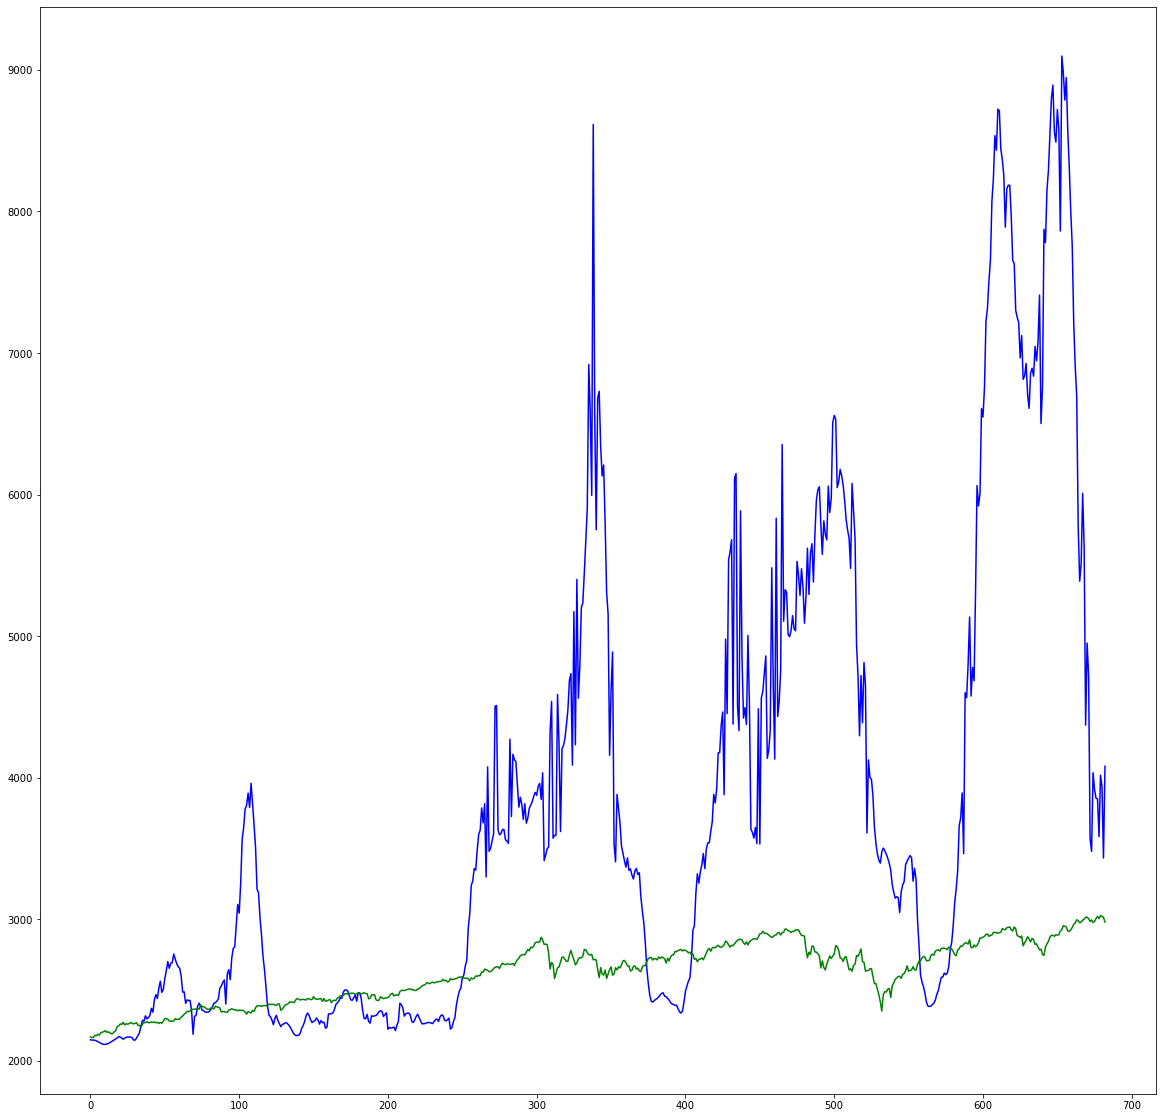

In [173]:
t = np.arange(len(y_pred))

fig, ax = plt.subplots()

plt.figure(figsize=(20,20))

plt.plot(t, y_pred, color='blue')
plt.plot(t, y_test, color='g')

plt.show;

array([ -5.47837689,   6.29901552,   4.19890463, ...,   1.68180016,
       -11.84867637, -21.39320807])

In [180]:
y[y['SPX close'] > 3000]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

### Recreating another MV Time Series